# Some explanations

## What is the pair correlation function?

In very short: the pair correlation function (pcf) represents "the amount of points found in average at a distance r of a given point in the sample". 
See the [Wikipedia page](https://en.wikipedia.org/wiki/Radial_distribution_function) for more information (but I assume that you're familiar with this notion if you are looking for a script that computes it).

## What do you mean by "corrected to take account of boundary effects"?

When the set of points is of finite size (which often occurs), some points near the boundaries will have less neighbours than what they would have in an infinite sample. This effect has to be corrected to properly compute the pcf.

This scripts has two methods to deal with boundaries:
- the "normalization factors method": for the points that are too close to a boundary, the number of other points found at a given distance from them will be corrected to take account of the fact that in the bulk those particles should have more neighbours. This is the default behavior: all the points are considered (i.e. no data is lost), at the price of a time consuming computation.

- the "exclusion method": all the points that are too close to a boundary are simply excluded from the computation. In this case, the computation is faster, at the price of dropping some points (i.e. losing data).

# A simple example:

In [30]:
import numpy as np
import matplotlib.pyplot as plt

from paircorrelation2d import pcf2d

## Create a hexagonal-like array of points
This will be the set of points for which we want to compute the pair correlation function in this example

In [49]:
l_size=100 #the points will be placed in a square of size l_size*l_size
noise_amp=0.25 #we add some noise to mimic "real" data

col=np.arange(l_size)
points=np.zeros((l_size*l_size,2))

noise=np.random.rand(l_size*l_size,2)*noise_amp

for ii in range(l_size):
    points[ii*l_size:(ii+1)*l_size,0]=col+np.ones(l_size)*(1+(-1)**ii)/4+noise[ii*l_size:(ii+1)*l_size,0]
    points[ii*l_size:(ii+1)*l_size,1]=np.ones(l_size)*ii+noise[ii*l_size:(ii+1)*l_size,1]

Let's look at the set of points:

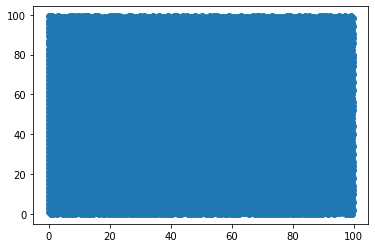

In [55]:
plt.scatter(points[:,0],points[:,1])

Let's look at a subset of points (to see the general pattern):

(10.0, 20.0, 10.0, 20.0)

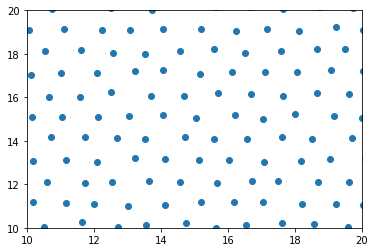

In [52]:
plt.scatter(points[:,0],points[:,1])
plt.axis([10,20,10,20])

## Compute the pair correlation function (pcf) taking account of all points:

In [37]:
bins=np.linspace(0,5,100) #Since the distance between two particles is about 1 here, 
#we choose to compute the pcf only for distances up to 5.

[g_of_r_all,r] = pcf2d(points,bins,show_timing=True) 
#the "show_timing" argument let you knows how long the script takes to run

Creating boundary polygon and array of points inside took 0.069000 s
Creating all ring polygons took 0.031243 s
Computing normalization factors took 31.433962 s
Computing g(r) took 8.100621 s


Here you can see that the total computation time is about 40 s (and that the computation of the normalization factor is the most time consuming operation).

Text(0.5, 1.0, 'Taking account of all points')

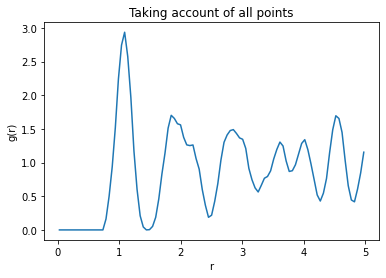

In [38]:
plt.plot(r,g_of_r_all)
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Taking account of all points')

## Compute the pair correlation function (pcf) excluding points too close to the boundary:

In [39]:
[g_of_r_exclude,r] = pcf2d(points,bins,fast_method=True,show_timing=True)
#the "show_timing" argument let you knows how long the script takes to run

Creating boundary polygon and array of points inside took 0.068860 s
Creating all ring polygons took 0.031245 s
Computing normalization factors took 0.138092 s
Computing g(r) took 5.382579 s


Here you can see that the total computation time is about 6 s (and that the computation of g(r) is faster than in the previous case because less points are considered).

Text(0.5, 1.0, 'Excluding points too close to the boundary')

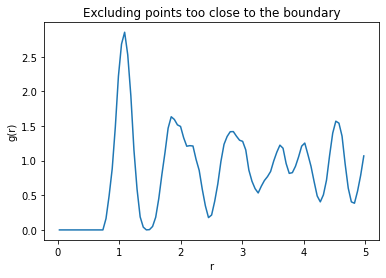

In [40]:
plt.plot(r,g_of_r_exclude)
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Excluding points too close to the boundary')

## Wait, they look exactly the same, don't they?

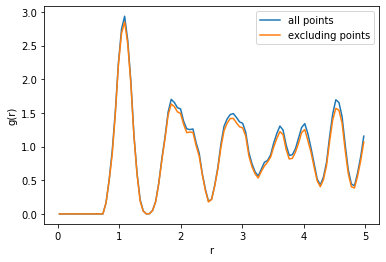

In [41]:
plt.plot(r,g_of_r_all,label='all points')
plt.plot(r,g_of_r_exclude,label='excluding points')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.legend()

This is because we have a set of points that is "bulky" (enough points are at a distance > 5 from the boundaries), but this is not always the case.

Let's take another set of points:

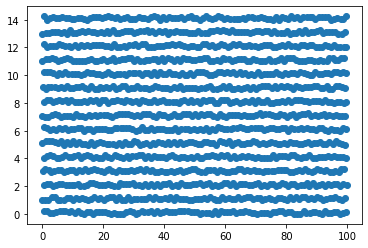

In [44]:
subpoints=points[np.where(points[:,1]<15)[0],:] #we exclude all the points with y>20

plt.scatter(subpoints[:,0],subpoints[:,1])

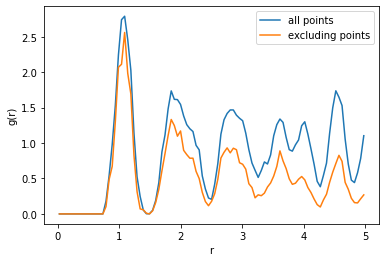

In [46]:
[g_of_r_all,r] = pcf2d(subpoints,bins)
[g_of_r_exclude,r] = pcf2d(subpoints,bins,fast_method=True)

plt.plot(r,g_of_r_all,label='all points')
plt.plot(r,g_of_r_exclude,label='excluding points')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.legend()

Here the difference is more noticeable, because more than half of the points are close enough to a boundary (i.e. their distance to the boundary is less than 5, which is the maximal distance we want for computing g(r)).

# More information about boundaries:

## You can define your one boundaries if you want: